## Step 1: Load & Preprocess the Data

In [2]:
import pandas as pd

# Load the dataset
df = pd.read_csv("train_FD001.txt", sep=' ', header=None)
df.dropna(axis=1, inplace=True)  # remove empty columns

# Assign column names
columns = ['unit_number', 'time_in_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + \
          [f'sensor_{i}' for i in range(1, 22)]
df.columns = columns

##  Step 2: Add the RUL Column

In [3]:

rul_df = df.groupby('unit_number')['time_in_cycles'].max().reset_index()
rul_df.columns = ['unit_number', 'max_cycle']
df = df.merge(rul_df, on='unit_number', how='left')
df['RUL'] = df['max_cycle'] - df['time_in_cycles']
df.drop('max_cycle', axis=1, inplace=True)

 ## Step 3: Feature Selection + Normalization

In [4]:
from sklearn.preprocessing import MinMaxScaler

drop_sensors = ['sensor_1', 'sensor_5', 'sensor_6', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']
df.drop(columns=drop_sensors, inplace=True)

sensor_cols = [col for col in df.columns if 'sensor' in col]
scaler = MinMaxScaler()
df[sensor_cols] = scaler.fit_transform(df[sensor_cols])

## Step 4: Train a Model to Predict RUL

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np  # Added import for np.sqrt

X = df.drop(['unit_number', 'time_in_cycles', 'RUL'], axis=1)
y = df['RUL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
# Calculate MSE first, then take square root to get RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Calculate RMSE manually
print("RMSE:", rmse)

RMSE: 41.36910647933985


## Step 5: Visualize the Results

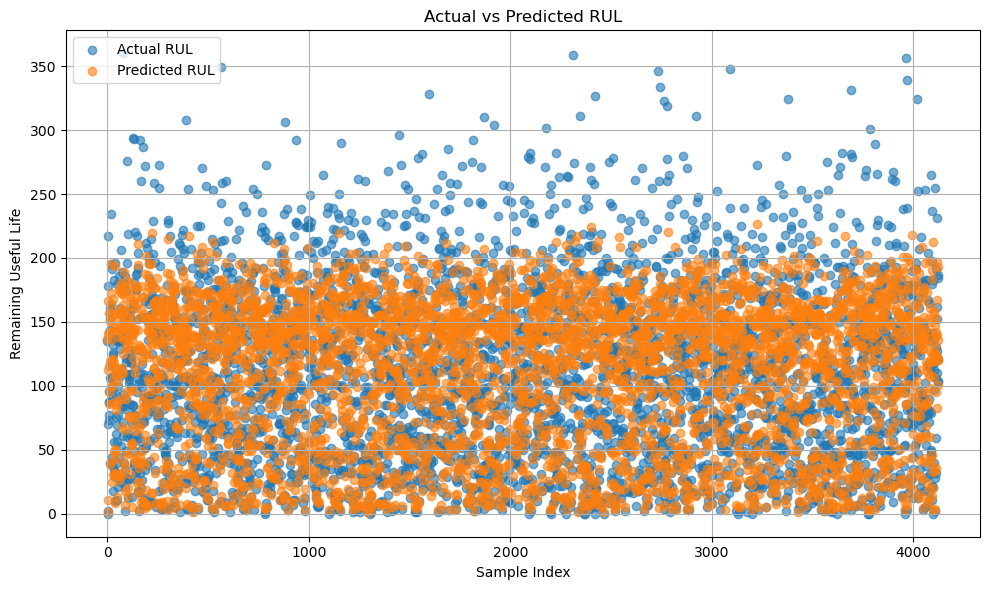

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.scatter(range(len(y_test)), y_test, label="Actual RUL", alpha=0.6)
plt.scatter(range(len(y_pred)), y_pred, label="Predicted RUL", alpha=0.6)
plt.xlabel("Sample Index")
plt.ylabel("Remaining Useful Life")
plt.title("Actual vs Predicted RUL")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()